In [1]:
import matplotlib.pylab
import matplotlib.pyplot
import sklearn
import sklearn.pipeline
from prepare_datasets import get_pruned_df, get_combined_df
from pprint import pprint
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

Models to use on dataset

In [2]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

get the DataFrame with the measured vals of the temperature combined and unnecessary columns removed

In [ ]:
prepared_df = get_pruned_df()
X = prepared_df.drop(columns=['real_temp'])
Y = prepared_df['real_temp']

make test data as last week

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y , shuffle=False, random_state=0, test_size=1047)

for future plotting and calculating predicted average arrays:

In [6]:
def get_temperature_df(df: pd.DataFrame = prepared_df, rows_from_last: int = -1047):
    df = df.iloc[-1047:].reset_index(drop=True)
    df = df[['real_temp','t2m']]
    original_df = get_combined_df()
    original_df = original_df[['time']].iloc[rows_from_last:].reset_index(drop=True)
    df = pd.concat([df,original_df], axis=1)
    df.to_csv("to_ignore/hmm.csv")
    return df

columns in the dataframe defined to scale/normalize their values 

In [7]:
columns_to_scale = ['cape','sp','tcw','sshf','slhf','msl','u10','v10','d2m','ssr','str','ttr','sund','sm','st','sd','sf','tcc','tp','mx2t6','mn2t6']

Time-series-based cross-validator

In [8]:
ts_cv = TimeSeriesSplit(n_splits=20)

In [9]:
column_scaler = ColumnTransformer(
        transformers=[
            ("To_scale",StandardScaler(),columns_to_scale)
        ]
    )

Linear (Ridge) Regression Pipeline 

In [10]:
ridge_pipeline = make_pipeline(
    column_scaler,
    GridSearchCV(estimator=Ridge(),param_grid={
        'alpha':[0,0.3,0.5,1.0,1.3,3,5]
    },scoring=["neg_mean_squared_error"],refit='neg_mean_squared_error', cv=ts_cv)
)

K-NN Regressor Pipeline

In [11]:
knn_pipeline = make_pipeline(
    column_scaler,
    GridSearchCV(KNeighborsRegressor(n_jobs=-1), param_grid={
        'n_neighbors': [5,6,7,8,9,10]
    }, scoring=['neg_mean_squared_error'], refit='neg_mean_squared_error', cv=ts_cv)
)

RandomForest Regressor Pipeline

In [12]:
randomforest_pipeline = make_pipeline(
        column_scaler,
        GridSearchCV(RandomForestRegressor(n_jobs=-1), param_grid={
            'max_features':[0.1,0.7,1],
            'n_estimators': [50,100]
        }, scoring=['neg_mean_squared_error'], refit='neg_mean_squared_error', cv=ts_cv)
    )

Fit the estimators to the training data and predict the target values using the test data after validation has finished

In [13]:
ridge_estimator = ridge_pipeline.fit(X_train,Y_train)
ridge_results = ridge_estimator.predict(X_test)

In [14]:
knn_estimator = knn_pipeline.fit(X_train, Y_train)
knn_results = knn_estimator.predict(X_test)

In [15]:
rf_estimator = randomforest_pipeline.fit(X_train, Y_train)
rf_results = rf_estimator.predict(X_test)

convert ndarray results to dataframe

In [16]:
knn_df = pd.DataFrame(knn_results, columns=['knn_results'])
ridge_df = pd.DataFrame(ridge_results, columns=['ridge_results'])
rf_df = pd.DataFrame(rf_results, columns=['randomforest_results'])

get temp columns and rename time to measured_time

In [ ]:
real_temp_df = get_temperature_df()
real_temp_df = real_temp_df.rename(columns={'time':'measured_time'})

reorder columns

In [18]:
cols = real_temp_df.columns.tolist()
# Move the last column to the first position
cols = [cols[-1]] + cols[:-1]
# reorder df
real_temp_df = real_temp_df[cols]

compute mean and group by time

In [19]:
real_temp_df = pd.concat([real_temp_df, knn_df, ridge_df, rf_df], axis=1)
real_temp_df = real_temp_df.groupby('measured_time').mean()
real_temp_df.reset_index(inplace=True)

plotting the results

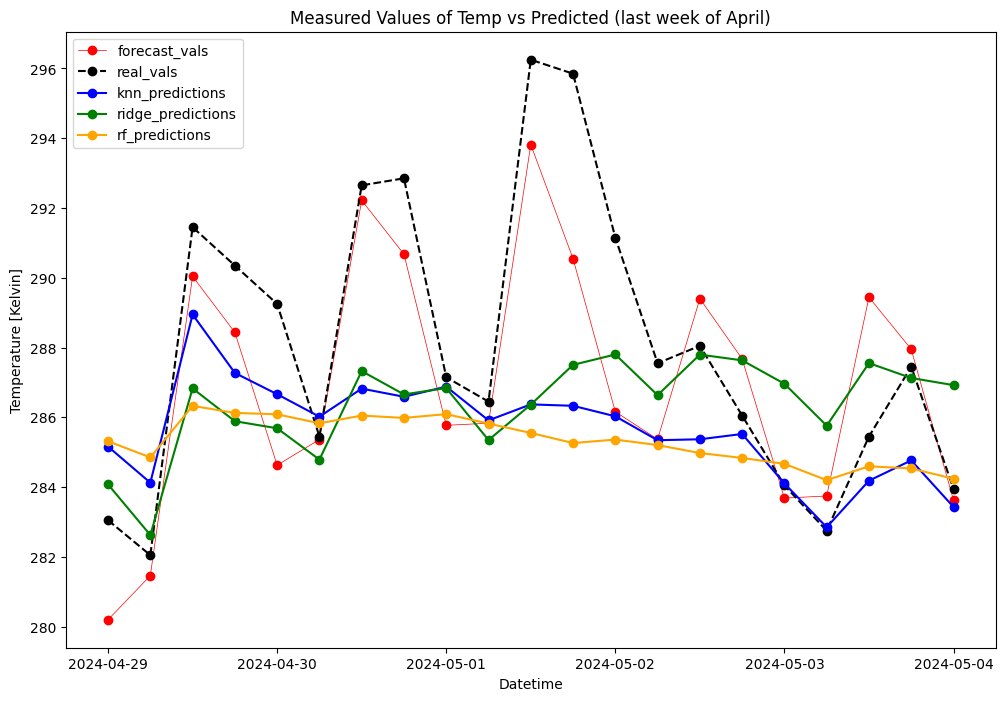

In [20]:
plt.figure(figsize=(12,8))
plt.plot(real_temp_df['measured_time'], real_temp_df['t2m'], color='red',marker='o',label='forecast_vals',linewidth='0.5')
plt.plot(real_temp_df['measured_time'], real_temp_df['real_temp'], color='black',marker='o',label='real_vals', linestyle='dashed')
plt.plot(real_temp_df['measured_time'], real_temp_df['knn_results'], color='blue',marker='o',label='knn_predictions')
plt.plot(real_temp_df['measured_time'], real_temp_df['ridge_results'], color='green',marker='o', label='ridge_predictions')
plt.plot(real_temp_df['measured_time'], real_temp_df['randomforest_results'], color='orange',marker='o', label='rf_predictions')
plt.legend(loc='upper left')
plt.title("Measured Values of Temp vs Predicted (last week of April)")
plt.xlabel("Datetime")
plt.ylabel("Temperature [Kelvin]")
plt.show()